# Problem Set 3

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

%matplotlib inline

# Question 2

## Roy Model of Schooling Choice
Consider thhe model of schooling choice ($D=1$ if college; $D=0$ if high school):

$$\mathrm{Y}_{1}=\alpha+\bar{\beta}+\mathrm{U}_{1} \quad \text{P.V. of income from college}$$

$$\mathrm{Y}_{0}=\alpha+\mathrm{U}_{0} \quad \text{P.V. of income from high school}$$

$$\mathrm{D}=\mathbf{1}\left\{\mathrm{Y}_{1}-\mathrm{Y}_{0}-\mathrm{C} \geq 0\right\}$$

$$\left.\left(\begin{array}{c}\mathrm{U}_{0} \\ \mathrm{U}_{1} \\ \mathrm{V}\end{array}\right) \sim \mathcal{N}\left(\begin{array}{ccc}\sigma_{0}^{2} & \sigma_{01} & \sigma_{0, \mathrm{V}} \\ \sigma_{01} & \sigma_{1}^{2} & \sigma_{1, \mathrm{V}} \\ \sigma_{0, \mathrm{V}} & \sigma_{1, \mathrm{V}} & \sigma_{\mathrm{V}}^{2}\end{array}\right]\right)$$

$$\mathrm{C}=\mathrm{Z}+\mathrm{V}, \quad \mathrm{Z} \text{ is tuition; } V \text{ is psychic costs}$$


\begin{array}{c}
\mathrm{Z} \perp\left(\mathrm{U}_{0}, \mathrm{U}_{1}, \mathrm{V}\right) \\
\mathrm{U}_{D}=\Phi\left(\frac{U_0 + V - U_1}{\sigma_{U_0 + V - U_1}}\right) \\
\alpha=0.67, \quad \bar{\beta}=0.2
\end{array}

For this model we have several configarations which are described below with $\Theta$, where
$$\Theta = [\sigma^2_1,\sigma^2_0,\sigma^2_V,\sigma_{01},\sigma_{0V},\sigma_{1V}]$$

In [77]:
#configurations
Θ_1 = [1, 1, 1, 0, 0, 0]

Θ_2 = [1, 1, 1, 0.5, -0.5, 0]

Θ_3 = [1, 1, 1, 0, 0, 0.5]

Θ_4 = [1, 1, 0, 0.5, 0, 0]

Θ_5 = [1, 0.25, 1, 0.1, -0.2, 0.2]

Θ_6 = [0.25, 0.25, 1, -0.2, 0.1, -0.2]

Θ_7 = [1, 1, 1, -0.2, 0.6, 0.5]

## Marginal treatment effect (MTE)
The MTE is a parameter which is defined as,
$$\Delta^{MTE}(u_D) = \mathbb{E}[Y_1 - Y_0 | U_D = u_d]$$
Given the assumptions above we can derive a closed form expression for $\Delta^{MTE}$.
\begin{align*}
    \Delta^{MTE}(u_D) =& \bar \beta  + \mathbb{E}\left[U_1-U_0\Big|\frac{U_0 + V - U_1}{\sigma_{U_0 + V - U_1}} = \Phi^{-1}(u_D) \right]\\
    =& \bar \beta  + Cov\left(U_1-U_0,\frac{U_0 + V - U_1}{\sigma_{U_0 + V - U_1}}\right) \Phi^{-1}(u_D)\\
    =& \bar \beta  + \frac{\gamma}{\sigma_{U_0 + V - U_1}} \Phi^{-1}(u_D)\\
\end{align*}
where $\gamma = 2\sigma_{01} + \sigma_{1V} - \sigma_{0V} - \sigma_1^2 - \sigma_0^2$, and we can evaluate $\sigma^2_{U_0+V-U_1}$ as,

$$\sigma^2_{U_0+V-U_1} = \begin{pmatrix} 1 , -1, 1 \end{pmatrix}\begin{pmatrix}\sigma_{0}^{2} & \sigma_{01} & \sigma_{0, V} \\ \sigma_{01} & \sigma_{1}^{2} & \sigma_{1, V} \\ \sigma_{0, V} & \sigma_{1, V} & \sigma_{V}^{2}\end{pmatrix}\begin{pmatrix} 1\\-1\\ 1 \end{pmatrix}= \sigma^2_0 + \sigma^2_1 + \sigma^2_V - 2(\sigma_{01} + \sigma_{1V} - \sigma_{0V})$$

The code below calculates the MTE for a given set of $u_d$'s.

In [87]:
##Define MTE function## 
def MTE(u_d= np.linspace(0.001,0.999,200), β =0.2 , Θ=[1,1,1,0,0,0]):
    
    # for ease of notation σ_i denote variance
    σ_1, σ_0, σ_v, σ_01, σ_0v, σ_1v = Θ[0],Θ[1],Θ[2],Θ[3],Θ[4],Θ[5]
    
    #calculate parameters needed to evaluate
    γ = 2*σ_01 + σ_1v - σ_0v - σ_1 - σ_0
    σ = (σ_1 + σ_0 + σ_v - 2*(σ_01 + σ_1v - σ_0v))**0.5 #this is standard deviation
    
    MTE = [β + (γ/σ)*norm.ppf(u) for u in u_d]
    
    return MTE,u_d

## Local Instrument Variable

A local instrument variable is defined as,
$$LIV = \frac{\partial \mathbb{E}[Y|P(Z)=p]}{\partial p}$$

We begin by finding an expression of the expression $\mathbb{E}[Y|P(Z)=p]$
\begin{align*}
    \mathbb{E}[Y|P(z) = p] =& \mathbb{E}[Y_0 + D(Y_1 - Y_0) | P(Z) = p]\\
                           =& \mathbb{E}[Y_1|D=1, P(Z) = p]P(D=1|Z=z) + \mathbb{E}[Y_0|D=0, P(Z) = p](1-P(D=1|Z=z))\\
                           =& \mathbb{E}[Y_1|P(Z)>U_D, P(Z) = p]p + \mathbb{E}[Y_0|P(Z)<U_D, P(Z) = p](1-p)\\
                           =& \alpha + \bar \beta p + \mathbb{E}[U_1|p>U_D]p + \mathbb{E}[U_0|p<U_D](1-p)\\
                           =& (\alpha + \bar \beta)p+ \mathbb{E}\left[U_1\Big|\frac{U_0 + V - U_1}{\sigma_{U_0 + V - U_1}}<\Phi^{-1}(p) \right]p\\
                           =& \alpha + \bar \beta p + \frac{\zeta_1}{\sigma_{U_0 + V - U_1}} \mathbb{E}\left[\frac{U_0 + V - U_1}{\sigma_{U_0 + V - U_1}}\Big|\frac{U_0 + V - U_1}{\sigma_{U_0 + V - U_1}}<\Phi^{-1}(p) \right]p\\
                           +& \frac{\zeta_0}{\sigma_{U_0 + V - U_1}} \mathbb{E}\left[\frac{U_0 + V - U_1}{\sigma_{U_0 + V - U_1}}\Big|\frac{U_0 + V - U_1}{\sigma_{U_0 + V - U_1}}>\Phi^{-1}(p) \right](1-p)\\
                           =& \alpha + \bar \beta p + \frac{\zeta_1}{\sigma_{U_0 + V - U_1}}  \frac{\mathbb{E}\left[\frac{U_0 + V - U_1}{\sigma_{U_0 + V - U_1}}\mathbf{1}\left\{\frac{U_0 + V - U_1}{\sigma_{U_0 + V - U_1}}<\Phi^{-1}(p)\right\} \right]}{P\left(\frac{U_0 + V - U_0}{\sigma_{U_0 + V - U_0}}<\Phi^{-1}(p)\right)}p\\ 
                           +& \frac{\zeta_0}{\sigma_{U_0 + V - U_1}}  \frac{\mathbb{E}\left[\frac{U_0 + V - U_1}{\sigma_{U_0 + V - U_1}}\mathbf{1}\left\{\frac{U_0 + V - U_1}{\sigma_{U_0 + V - U_1}}>\Phi^{-1}(p)\right\} \right]}{P\left(\frac{U_0 + V - U_1}{\sigma_{U_0 + V - U_1}}>\Phi^{-1}(p)\right)}(1-p)\\
                           =& \alpha + \bar \beta p + \frac{\zeta_1}{\sigma_{U_0 + V - U_1}} \frac{\int_{\Phi^{-1}(p)}^{\infty}t\phi(t)dt}{\int_{\Phi^{-1}(p)}^{\infty}\phi(t)dt}p + \bar \beta)p + \frac{\zeta_0}{\sigma_{U_0 + V - U_1}} \frac{\int_{-\infty}^{\Phi^{-1}(p)}t\phi(t)dt}{\int_{-\infty}^{\Phi^{-1}(p)}\phi(t)dt}(1-p)\\
                           =& \alpha + \bar \beta - \frac{\zeta_1}{\sigma_{U_0 + V - U_1}}\frac{\int_{-\infty}^{\Phi^{-1}(p)}\phi'(t)dt}{\int_{-\infty}^{\Phi^{-1}(p)}\phi(t)dt}p - \frac{\zeta_0}{\sigma_{U_0 + V - U_1}}\frac{\int_{\Phi^{-1}(p)}^{\infty}\phi'(t)dt}{\int_{\Phi^{-1}(p)}^{\infty}\phi(t)dt}(1-p) \tag{$\phi'(t) = -t\phi(t)$}\\
                           =&  \alpha + \bar \beta p - \frac{\zeta_1 - \zeta_0}{\sigma_{U_0 + V - U_1}} \phi(\Phi^{-1}(p))
\end{align*}
where $\zeta_1 = \sigma_{01} + \sigma_{1V} - \sigma^2_1$ and $\zeta_0 = \sigma^2_{0} + \sigma_{0V} - \sigma_{01}$. Taking derivative of the expression above with respect to $p$ we get,
\begin{align*}
    \frac{\partial \mathbb{E}[Y|P(Z)=p]}{\partial p} =& \bar \beta -\frac{\zeta_1 - \zeta_0}{\sigma_{U_1 - U_0 - V}} \phi'(\Phi^{-1}(p))(\Phi^{-1})'(p)\\
                                                     =& \bar \beta -\frac{\zeta_1 - \zeta_0}{\sigma_{U_1 - U_0 - V}} \frac{\phi'(\Phi^{-1}(p))}{\phi(\Phi^{-1}(p))} \tag{inverse derivative theorem}\\
                                                     =& \bar \beta + \frac{\zeta_1 - \zeta_0}{\sigma_{U_1 - U_0 - V}} \Phi^{-1}(p) \tag{$\phi'(t) = -t\phi(t)$}
\end{align*}

We can evaluate p from z, namely, $p=P(z)$ is given by,
\begin{align*}
    p =& P(D=1|Z=z) = Pr(Y_1 -Y_0 - Z - V \geq 0 |Z=z) = P\left(\frac{U_0 + V - U_1}{\sigma_{U_0 + V - U_1}} \leq \frac{\bar \beta - Z}{\sigma_{U_0 + V - U_1}}\right)\\
      =& \Phi\left(\frac{\bar \beta - Z}{\sigma_{U_0 + V - U_1}}\right)
\end{align*}

The code below calculates LIV for a given set of z's.

In [94]:
##Define LIV function#
def LIV(values= np.linspace(-0.5,0.5,1200), α = 0.67, β =0.2 , Θ=[1,1,1,0,0,0]):

    # for ease of notation σ_i denote variance
    σ_1, σ_0, σ_v, σ_01, σ_0v, σ_1v = Θ[0],Θ[1],Θ[2],Θ[3],Θ[4],Θ[5]
    
    #calculate parameters needed to evaluate
    ζ_0 = σ_0 + σ_0v -σ_01
    ζ_1 = σ_01 + σ_1v - σ_1  
    σ = (σ_1 + σ_0 + σ_v - 2*(σ_01 + σ_1v - σ_0v))**0.5 #this is standard deviation
    
    #calculate propensity scores for the set of z
    p = [norm.cdf((β - z)/σ) for z in values]
    LIV = [β + ((ζ_1 - ζ_0)/σ)*norm.ppf(u) for u in p]
    
    return LIV, p

## Part A and B: Comparing MTE and LIV plots

Below we plot MTE and LIV for the various configurations of the Roy model introduced above.

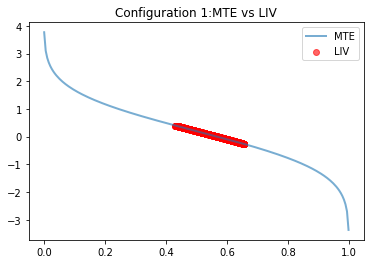

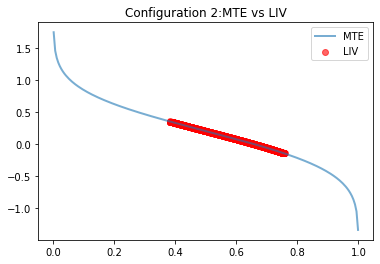

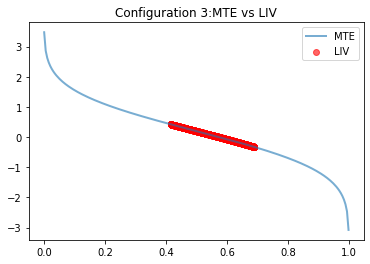

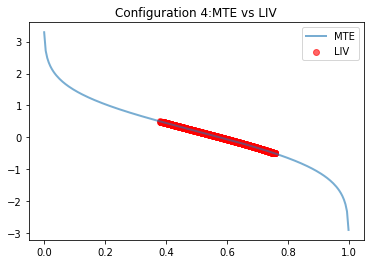

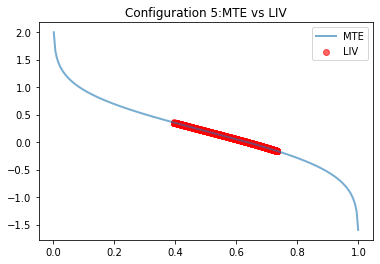

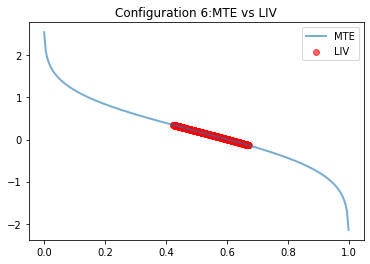

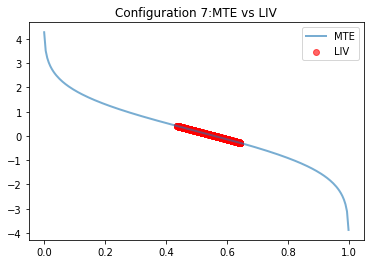

In [95]:
for i in range(1,8,1):
    parameters = globals()["Θ_" + str(i)]
    m = MTE(Θ=parameters)
    l = LIV(Θ=parameters)
    
    fig, ax = plt.subplots()
    ax.plot(m[1], m[0], linewidth=2, alpha=0.6, label='MTE')
    ax.scatter(l[1], l[0],c='red', alpha=0.6, label='LIV')
    ax.legend(loc='best')
    ax.set_title('Configuration '+str(i)+ ':MTE vs LIV')
    plt.show()

# Question 3
## Part A
$$Z \sim U[-0.1,0.1]$$

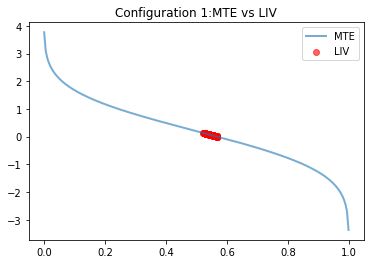

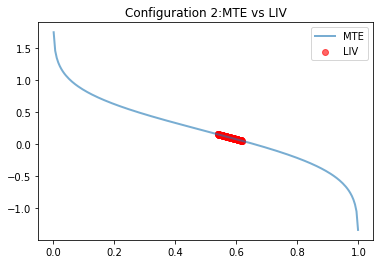

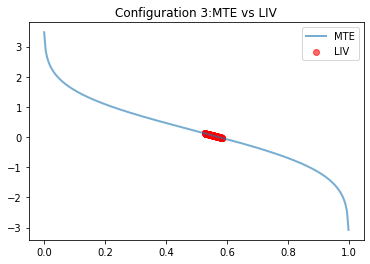

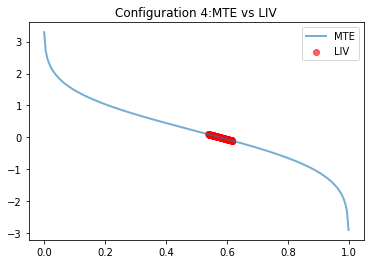

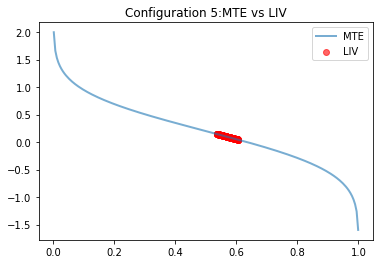

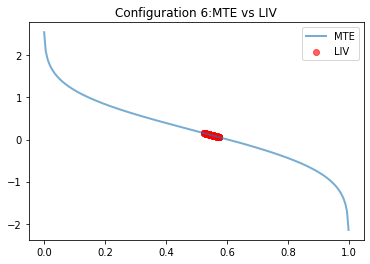

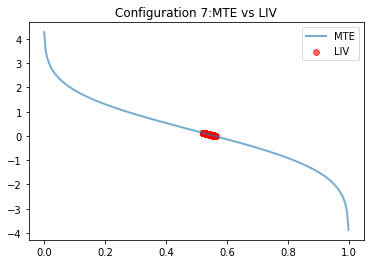

In [96]:
for i in range(1,8,1):
    parameters = globals()["Θ_" + str(i)]
    m = MTE(Θ=parameters)
    l = LIV(values= np.linspace(-0.1,0.1,200), Θ=parameters)
    
    fig, ax = plt.subplots()
    ax.plot(m[1], m[0], linewidth=2, alpha=0.6, label='MTE')
    ax.scatter(l[1], l[0],c='red', alpha=0.6, label='LIV')
    ax.legend(loc='best')
    ax.set_title('Configuration '+str(i)+ ':MTE vs LIV')
    plt.show()

## Part B
$$Z \sim U[0,0]$$

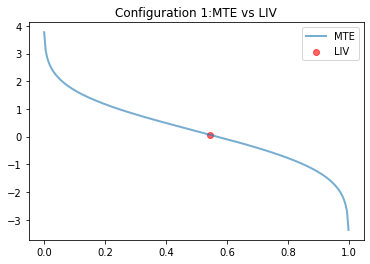

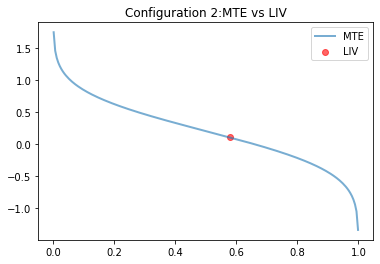

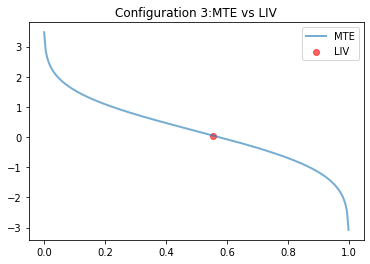

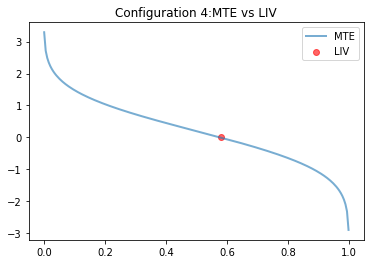

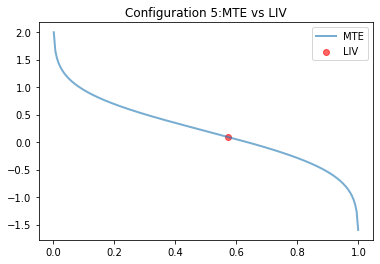

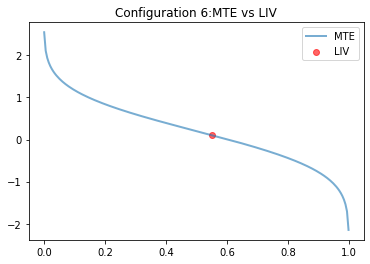

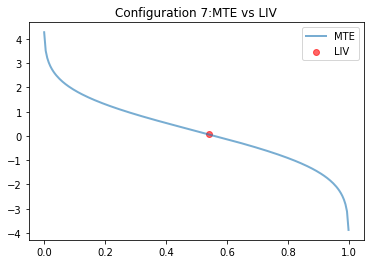

In [97]:
for i in range(1,8,1):
    parameters = globals()["Θ_" + str(i)]
    m = MTE(Θ=parameters)
    l = LIV(values= [0], Θ=parameters)
    
    fig, ax = plt.subplots()
    ax.plot(m[1], m[0], linewidth=2, alpha=0.6, label='MTE')
    ax.scatter(l[1], l[0],c='red', alpha=0.6, label='LIV')
    ax.legend(loc='best')
    ax.set_title('Configuration '+str(i)+ ':MTE vs LIV')
    plt.show()

## Part C
$$Z \sim U[-0.5,-0.3] \cup U[0.3,0.5]$$

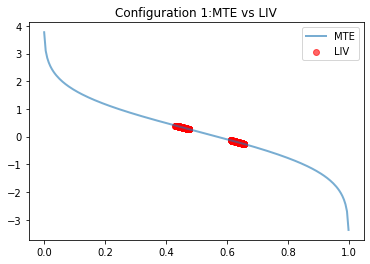

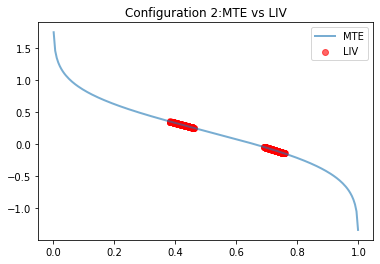

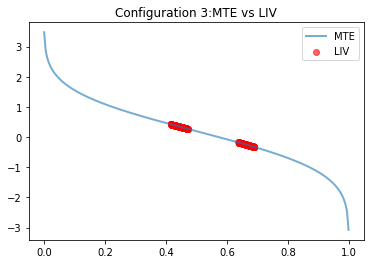

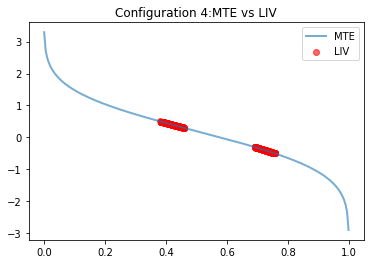

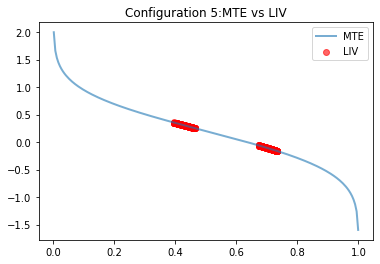

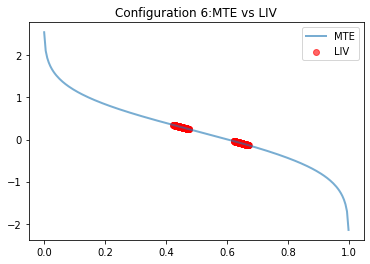

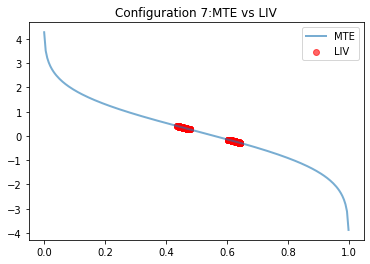

In [98]:
for i in range(1,8,1):
    parameters = globals()["Θ_" + str(i)]
    m = MTE(Θ=parameters)
    l = LIV(values= np.concatenate((np.linspace(-0.5,-0.3,200), np.linspace(0.3,0.5,200),)), Θ=parameters)
    
    fig, ax = plt.subplots()
    ax.plot(m[1], m[0], linewidth=2, alpha=0.6, label='MTE')
    ax.scatter(l[1], l[0],c='red', alpha=0.6, label='LIV')
    ax.legend(loc='best')
    ax.set_title('Configuration '+str(i)+ ':MTE vs LIV')
    plt.show()

## Code Check for full domain of Z

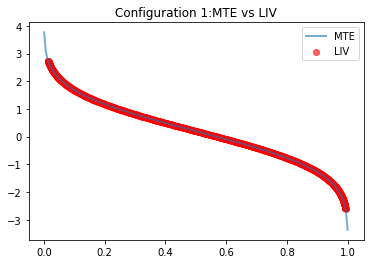

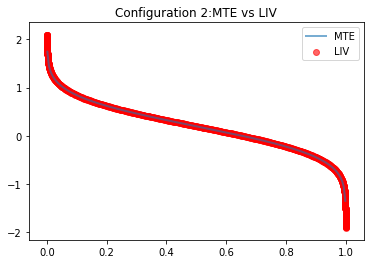

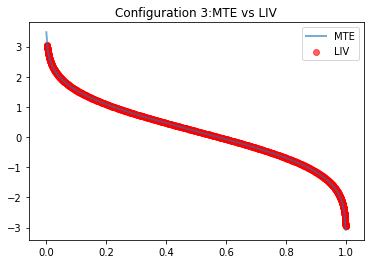

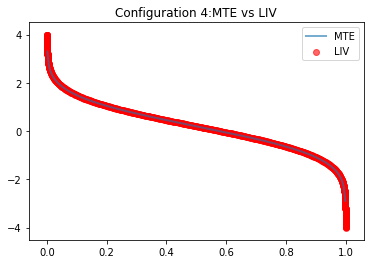

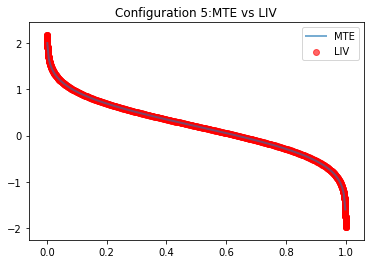

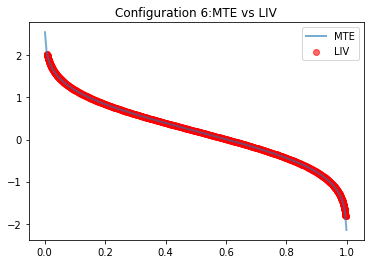

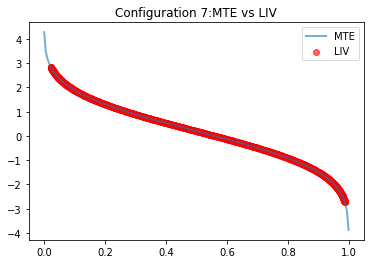

In [99]:
#check

for i in range(1,8,1):
    parameters = globals()["Θ_" + str(i)]
    m = MTE(Θ=parameters)
    l = LIV(values= np.linspace(-4,4,1000), Θ=parameters)
    
    fig, ax = plt.subplots()
    ax.plot(m[1], m[0], linewidth=2, alpha=0.6, label='MTE')
    ax.scatter(l[1], l[0],c='red', alpha=0.6, label='LIV')
    ax.legend(loc='best')
    ax.set_title('Configuration '+str(i)+ ':MTE vs LIV')
    plt.show()